In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('SA_df_random.csv')

In [4]:
one_hot_columns = [ 'month_of_year','day_of_week']#,'pickup_category_area','dropoff_category_area', 'is_weekend' ]

embedding_columns = [ 'pickup_census_tract', 'dropoff_census_tract','hour_of_day']#, 'pickup_community_area','dropoff_community_area', 'taxi_id_int']

numeric_columns = ['gc_distance', 'trip_miles', 'trip_seconds']

In [5]:
#for column in one_hot_columns
df = pd.get_dummies(df, columns=[column for column in one_hot_columns])

In [6]:
def extract_one_hot_encoded_columns(full_cols, one_hot_cols):
    one_hot_encoded_columns = []
    for col in one_hot_cols:
        one_hot_encoded_columns.extend([full_col for full_col in full_cols if full_col.startswith(col+'_')])
    return one_hot_encoded_columns

In [7]:
one_hot_encoded_columns = extract_one_hot_encoded_columns(df.columns,one_hot_columns )

In [8]:
df_one_hot = df[one_hot_encoded_columns]

In [9]:
for column in embedding_columns:
    df[column] = df[column].astype('category').cat.codes

In [10]:
df_embedding = df[embedding_columns]

In [11]:
df_numeric = df[numeric_columns]

In [12]:
df_numeric

,gc_distance,trip_miles,trip_seconds
0,5.66,6.80,900
1,0.99,2.59,1230
2,0.99,1.20,420
3,3.40,3.80,976
4,0.51,0.93,514
...,...,...,...
99995,0.88,1.10,420
99996,0.82,1.79,432
99997,1.83,2.17,840
99998,0.74,1.25,655


In [13]:
# Embedding sizes for the three categorical features
embedding_sizes = [min(16, df[column].nunique() // 2) for column in embedding_columns]


In [14]:
X = df[[*one_hot_encoded_columns, *embedding_columns, *numeric_columns]]
y = df['fare']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
X_train_one_hot = X_train[one_hot_encoded_columns].values
X_train_embedding = [X_train[embedding_column].values for embedding_column in embedding_columns]
X_train_numeric = X_train[numeric_columns].values

In [17]:
X_test_one_hot = X_test[one_hot_encoded_columns].values
X_test_embedding = [X_test[embedding_column].values for embedding_column in embedding_columns]
X_test_numeric = X_test[numeric_columns].values

In [18]:
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

In [19]:
# Building the model input layers and embedding layers
input_layers = []
embedding_layers = []

# Input and embedding for each categorical feature
for i, (input_dim, output_dim) in enumerate(zip(df[embedding_columns].nunique(), embedding_sizes)):
    input_layer = Input(shape=(1,))
    embedding_layer = Embedding(input_dim+1, output_dim, input_length=1)(input_layer)
    embedding_layer = Flatten()(embedding_layer)
    
    input_layers.append(input_layer)
    embedding_layers.append(embedding_layer)

# Input layer for one-hot encoded features
one_hot_input_layer = Input(shape=(X_train_one_hot.shape[1],))
input_layers.append(one_hot_input_layer)

# Input layer for numeric features
numeric_input_layer = Input(shape=(X_train_numeric.shape[1],))
input_layers.append(numeric_input_layer)

# Concatenate all layers
concatenated_layers = concatenate(embedding_layers + [one_hot_input_layer, numeric_input_layer])


In [20]:
# Dense layers
dense1 = Dense(256, activation='relu')(concatenated_layers)
dense2 = Dense(256, activation='relu')(dense1)
dense3 = Dense(256, activation='relu')(dense2)
dense4 = Dense(64, activation='relu')(dense3)
output = Dense(1)(dense4)

In [21]:
model = Model(inputs=input_layers, outputs=output)

In [22]:
model.compile(optimizer=Adam(learning_rate=0.0003), loss='mae', metrics=['mae'])

In [23]:
calbacks = [EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)]

# Train the model
history = model.fit(
    X_train_embedding + [X_train_one_hot, X_train_numeric],
    y_train,
    validation_split=0.3,
    batch_size=256,
    callbacks=calbacks,
    epochs=150)


Epoch 1/150
192/192 [==============================] - 2s 7ms/step - loss: 3.1400 - mae: 3.1400 - val_loss: 0.6992 - val_mae: 0.6992
Epoch 2/150
192/192 [==============================] - 1s 6ms/step - loss: 0.7638 - mae: 0.7638 - val_loss: 0.5399 - val_mae: 0.5399
Epoch 3/150
192/192 [==============================] - 1s 6ms/step - loss: 0.6139 - mae: 0.6139 - val_loss: 0.4585 - val_mae: 0.4585
Epoch 4/150
192/192 [==============================] - 1s 7ms/step - loss: 0.5673 - mae: 0.5673 - val_loss: 0.4546 - val_mae: 0.4546
Epoch 5/150
192/192 [==============================] - 1s 7ms/step - loss: 0.5508 - mae: 0.5508 - val_loss: 0.4232 - val_mae: 0.4232
Epoch 6/150
192/192 [==============================] - 1s 7ms/step - loss: 0.5324 - mae: 0.5324 - val_loss: 0.4088 - val_mae: 0.4088
Epoch 7/150
192/192 [==============================] - 1s 7ms/step - loss: 0.5257 - mae: 0.5257 - val_loss: 0.4077 - val_mae: 0.4077
Epoch 8/150
192/192 [==============================] - 2s 8ms/step - 

192/192 [==============================] - 1s 7ms/step - loss: 0.4219 - mae: 0.4219 - val_loss: 0.4003 - val_mae: 0.4003
Epoch 63/150
192/192 [==============================] - 1s 8ms/step - loss: 0.4207 - mae: 0.4207 - val_loss: 0.3909 - val_mae: 0.3909
Epoch 64/150
192/192 [==============================] - 2s 8ms/step - loss: 0.4185 - mae: 0.4185 - val_loss: 0.3989 - val_mae: 0.3989
Epoch 65/150
192/192 [==============================] - 1s 8ms/step - loss: 0.4214 - mae: 0.4214 - val_loss: 0.4161 - val_mae: 0.4161
Epoch 66/150
192/192 [==============================] - 1s 8ms/step - loss: 0.4174 - mae: 0.4174 - val_loss: 0.3977 - val_mae: 0.3977
Epoch 67/150
192/192 [==============================] - 1s 8ms/step - loss: 0.4239 - mae: 0.4239 - val_loss: 0.3916 - val_mae: 0.3916
Epoch 68/150
192/192 [==============================] - 1s 8ms/step - loss: 0.4129 - mae: 0.4129 - val_loss: 0.3959 - val_mae: 0.3959
Epoch 69/150
192/192 [==============================] - 1s 8ms/step - loss:

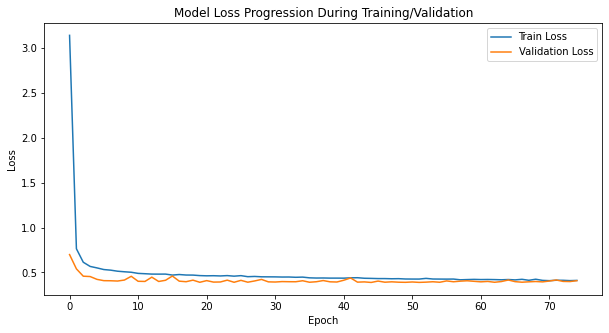

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [25]:
preds = model.predict(X_test_embedding + [X_test_one_hot, X_test_numeric])

In [26]:
r2_score(y_test, preds)

0.3674102899051135

In [27]:
mean_absolute_percentage_error(y_test, preds)

0.14805161410282536

In [28]:
mean_absolute_error(y_test, preds)

0.5009274647518793

In [29]:
mean_squared_error(y_test, preds)

303.90076344294

Text(0, 0.5, 'Predicted Values')

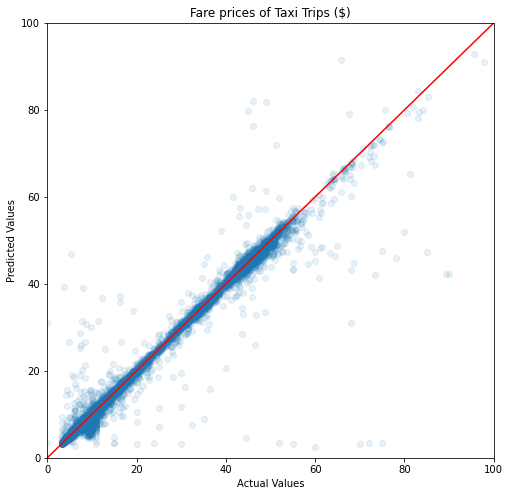

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(y_test.values.reshape(30000, 1), preds.reshape(30000, 1), alpha=0.1)
plt.plot(np.arange(len(y_test)), np.arange(len(y_test)), 'r')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Fare prices of Taxi Trips ($)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_series_without_outliers(series, whisker_width=1.5):
    """
    Plot the distribution of a pandas Series excluding outliers.
    
    :param series: pandas Series containing the data to plot
    :param whisker_width: the multiplier for IQR to determine outliers (default is 1.5)
    """
    # Calculate Q1, Q3 and IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - whisker_width * IQR
    upper_bound = Q3 + whisker_width * IQR
    
    # Remove outliers
    filtered_series = series[(series >= lower_bound) & (series <= upper_bound)]
    
    # Plot the distribution of the non-outlier values
    plt.figure(figsize=(10, 6))
    filtered_series.hist(bins=50, edgecolor='k')
    plt.title('Distribution without Outliers')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.grid(False)
    plt.show()


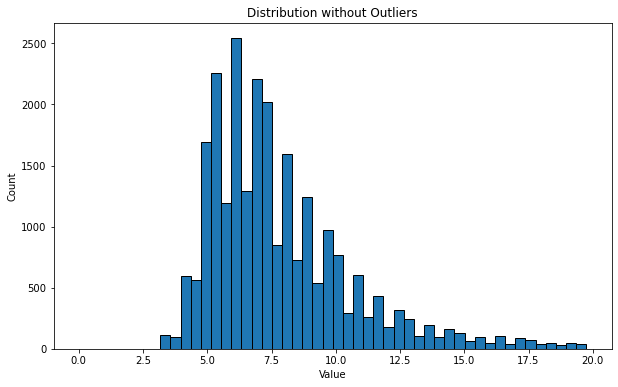

In [35]:
plot_series_without_outliers(pd.Series(y_test))